In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns
import statsmodels.api as sm

sns.set_style("whitegrid")

/home/ztang484/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/ztang484/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
df = pd.read_csv("azdiabetes.dat", delim_whitespace=' ')
df

,npreg,glu,bp,skin,bmi,ped,age,diabetes
0,5,86,68,28,30.2,0.364,24,No
1,7,195,70,33,25.1,0.163,55,Yes
2,5,77,82,41,35.8,0.156,35,No
3,0,165,76,43,47.9,0.259,26,No
4,0,107,60,25,26.4,0.133,23,No
...,...,...,...,...,...,...,...,...
527,2,88,58,26,28.4,0.766,22,No
528,9,170,74,31,44.0,0.403,43,Yes
529,10,101,76,48,32.9,0.171,63,No
530,5,121,72,23,26.2,0.245,30,No


In [4]:
X = sm.add_constant(df.loc[:, [c for c in df.columns if c not in ['glu', 'diabetes']]])
y = df['glu']

/home/ztang484/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [5]:
N, p = X.shape

with pm.Model() as model:
    X_tt = pm.Data('X_tt', X)
    y_tt = pm.Data('y_tt', y if y is not None else np.zeros(N))

    z = pm.Bernoulli('z', p=0.5, shape=(p, ))
    τ = pm.Gamma('τ', alpha=2/2, beta=(2*1)/2)
    g_prior_cov = 1/τ * N * np.linalg.inv(X.T@X)
    β = pm.MvNormal('β', mu=np.zeros(p), cov=g_prior_cov, shape=(p, ))
    zβ = pm.Deterministic('zβ', pm.math.prod([z, β], axis=0))

    likelihood = pm.Normal('y', mu=pm.math.dot(X_tt, zβ), tau=τ, observed=y_tt)

In [34]:
with model:
    post_ss = pm.sample(3000, tune=5000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [z]
>NUTS: [β, τ]


Sampling 4 chains for 5_000 tune and 3_000 draw iterations (20_000 + 12_000 draws total) took 126 seconds.
/home/ztang484/miniconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 1603 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.30308746248516416, but should be close to 0.8. Try to increase the number of tuning steps.
There were 263 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1215 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48648206698345287, but should be close to 0.8. Try to increase the number of tuning steps.
There were 365 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat stati

array([[<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'z'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'τ'}>,
        <AxesSubplot:title={'center':'τ'}>],
       [<AxesSubplot:title={'center':'zβ'}>,
        <AxesSubplot:title={'center':'zβ'}>]], dtype=object)

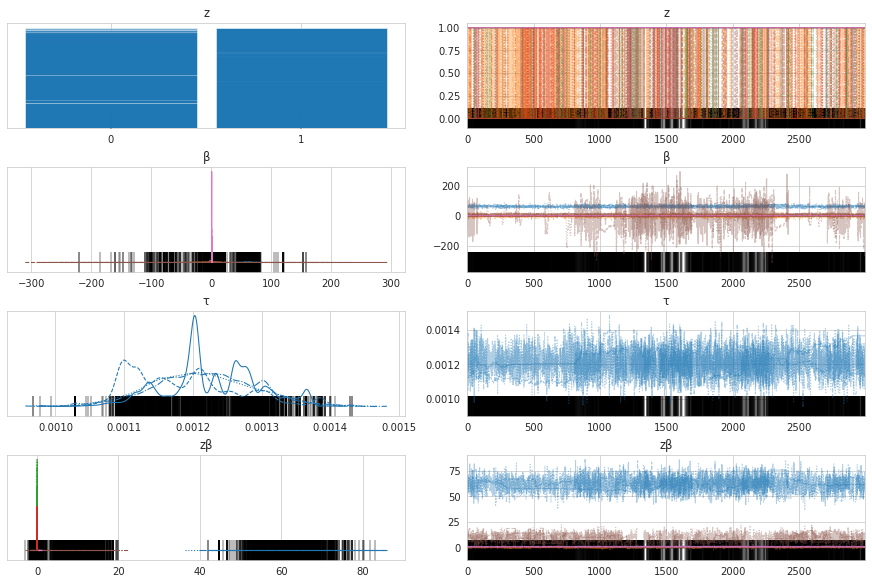

In [35]:
az.plot_trace(post_ss)

In [36]:
pd.DataFrame(post_ss['posterior']['zβ'][0].to_numpy()).quantile([0.025, 0.975])

,0,1,2,3,4,5,6
0.025,54.135960,-0.778727,-0.054786,-0.0,0.750692,0.00000,0.590581
0.975,75.683799,0.000000,0.000000,0.0,1.241418,16.15927,0.905569


In [37]:
pd.DataFrame(1/post_ss['posterior']['τ'][0].to_numpy()).quantile([0.025, 0.975])

,0
0.025,732.491731
0.975,910.109844


<AxesSubplot:>

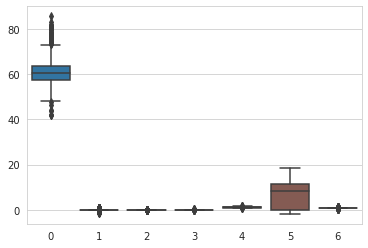

In [43]:
sns.boxplot(pd.DataFrame(post_ss['posterior']['zβ'][0].to_numpy()))

In [54]:
with model:
    pp = pm.sample_posterior_predictive(post_ss, samples=2000, var_names=['z', 'zβ'])

/home/ztang484/miniconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


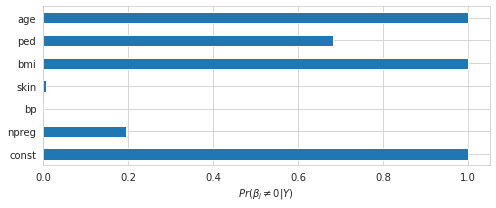

In [66]:
fig, ax = plt.subplots(figsize=(7, 3))
sr = pd.Series(pp['z'].mean(0))
sr.index = X.columns
sr.plot(kind='barh', ax=ax)

ax.set_xlabel("$Pr(\\beta_j \\neq 0|Y)$")
fig.tight_layout()
fig.show()

In [62]:
pd.DataFrame(pp['zβ']).quantile([0.025, 0.975])

,0,1,2,3,4,5,6
0.025,53.807830,-0.864191,-0.0,0.0,0.757513,0.00000,0.590269
0.975,74.088705,0.000000,0.0,0.0,1.254916,14.18453,0.912181
